In [ ]:
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng        # latex libraries

# 2D Shallow water

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import animation
%matplotlib inline

The 2D shallow water equations are as follows:

\begin{align}
    \frac{\partial h}{\partial t} &+ \frac{\partial q_{x}}{\partial t} +\frac {\partial q_{y}}{\partial t} = 0\\

    \frac{\partial q_{x}}{\partial t} &+ \frac{\partial }{\partial t} \bigg(\frac{q^2_{x}}{h}+\frac{gh^2}{2}\bigg)+\frac {\partial }{\partial t}\bigg(\frac{q_{x}q_{y}}{h}\bigg) = -gh\frac{\partial f}{\partial x}-\frac{\mu}{\rho}\frac{3 q_{x}}{h^2}  \\

    \frac{\partial q_{y}}{\partial t} &+ \frac{\partial }{\partial t} \bigg(\frac{q_{x}q_{y}}{h}\bigg)+\frac {\partial }{\partial t}\bigg(\frac{q^2_{y}}{h}+\frac{gh^2}{2}\bigg) = -gh\frac{\partial f}{\partial y}-\frac{\mu}{\rho}\frac{3 q_{y}}{h^2} \\

\end{align}


with: $$q_{x}=hu, \hspace{2mm} q_{y}=hv$$

Thus we find:

\begin{align*}
U = \begin{pmatrix} h\\hu\\hv \end{pmatrix}, F1(U) = \begin{pmatrix} hu\\hu^{2} + \frac{1}{2}gh^{2}\\huv \end{pmatrix} , F2(U) = \begin{pmatrix} hv\\huv\\hv^{2} + \frac{1}{2}gh^{2} \end{pmatrix} , S(U) = \begin{pmatrix} 0\\-gh(S_{0x} + S_{fx})\\-gh(S_{0y}+S_{fy}) \end{pmatrix} 
\end{align*}



In 2D, we have:

 $$ \frac{\partial U}{\partial t} +\frac{\partial F1(U)}{\partial x}+\frac{\partial F2(U)}{\partial y}  = S(U) $$

Using the MacCormack implementation we find the following numerical scheme to implement including:

1.Predictor step
$$U_{i,j}^{*} = U_{i,j}^n - \Delta t \bigg( \frac{F1(U_{i+1,j}^n) - F1(U_{i,j}^n)}{\Delta x} + \frac{F2(U_{i,j+1}^n) - F2(U_{i,j}^n)}{\Delta y}-S(U_{i,j}^n) \bigg) $$

2.Corrector step

$$ U_{i,j}^{n+1} = \frac{U_{i,j}^{n} + U_{i,j}^{*}}{2} + \Delta t \bigg( S(U_{i,j}^*) - \frac{F1(U_{i,j}^*) - F1(U_{i-1,j}^*)}{\Delta x} - \frac{F2(U_{i,j}^*) - F2(U_{i,j-1}^*)}{\Delta y}\bigg)$$

$\underline{\text{Discretization}}$ \\
Before heading to the system solving, we will briefly detail the 2D discretization, and so once again do the link between physical functions and numerical model. 

We recall that the general formula for a quantity variation is given under global form as :

$$ \underbrace{\dfrac{\partial}{\partial t}\iiint_{\Omega} c ~ \,dV}_{\text{greatness variation}} = \underbrace{- \iint \underline{j}\cdot\underline{n} \,dS}_{\text{flux/exchange}} + \underbrace{\iiint_{\Omega} \phi ~ \,dV}_{\text{Production/absorbtion}} $$

Similarly to the 1D case, we integrate over a unit cell :

$\hspace{10cm}$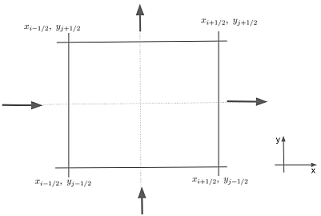

Doing then the mean with respect to both widths $\Delta x$ and $\Delta y$ one then obtain :

$$ \dfrac{\partial}{\partial t}\dfrac{1}{\Delta x \Delta y}\iint_{\Omega} U(x,y,t) ~ \,dx \,dy = - \dfrac{1}{\Delta x \Delta y} \iint_{\Omega} \partial_x F_1(x,y,t) \,dx \,dy - \dfrac{1}{\Delta x \Delta y} \iint_{\Omega} \partial_y F_2(x,y,t) \,dx \,dy + \dfrac{1}{\Delta x \Delta y} \iint_{\Omega} S \,dx \,dy$$

Eventually :

\begin{align*}
U_{i,j} &= \dfrac{1}{\Delta x \Delta y}\iint_{\Omega} U(x,y,t) ~ \,dx \,dy 
\\
\dfrac{1}{\Delta x \Delta y} \iint_{\Omega} \partial_x F_1(x,y,t) \,dx \,dy &=  \dfrac{1}{\Delta x \Delta y} \int_{\Omega} (F_1(x_{i+1/2},y,t) - F_1(x_{i-1/2},y,t)) \,dy
\\
\dfrac{1}{\Delta x \Delta y} \iint_{\Omega} \partial_y F_2(x,y,t) \,dx \,dy &= \dfrac{1}{\Delta x \Delta y} \int_{\Omega} (F_2(x,y_{j+1/2},t) - F_2(x,y_{j-1/2},t)) \,dx
\\
S_{i,j} &= \dfrac{1}{\Delta x \Delta y} \iint_{\Omega} S \,dx \,dy
\end{align*}

Yet : \\
\begin{align*}
&\dfrac{1}{\Delta x \Delta y} \int_{\Omega} (F_1(x_{i+1/2},y,t) - F_1(x_{i-1/2},y,t)) \,dy = \dfrac{1}{\Delta x} (F_1(x_{i+1/2},y_{j},t) - F_1(x_{i-1/2},y_{j},t) = \dfrac{1}{\Delta x} (F_{1_{i+1/2,~j}} - F_{1_{i-1/2,~j}}) \\
&\dfrac{1}{\Delta x \Delta y} \int_{\Omega} (F_2(x,y_{i+1/2},t) - F_2(x,y_{i-1/2},t)) \,dx = \dfrac{1}{\Delta y} (F_2(x_{i},y_{j+1/2},t) - F_2(x_{i},y_{j-1/2},t) = \dfrac{1}{\Delta y} (F_{2_{i,~j+1/2}} - F_{2_{i,~j-1/2}}) \\
\end{align*}

By assembly :

\begin{equation*}
\frac{\partial}{\partial t} U_{i,j} = - \dfrac{1}{\Delta x} (F_{1_{i+1/2,~j}} - F_{1_{i-1/2,~j}}) - \dfrac{1}{\Delta y} (F_{2_{i,~j+1/2}} - F_{2_{i,~j-1/2}}) + S_{ij}
\end{equation*}

and using forward (explicit Euler) :

\begin{equation*}
U_{i,j}^{n+1} = U_{i,j}^{n} - \dfrac{\Delta t}{\Delta x} (F_{1_{i+1/2,~j}}^n - F_{1_{i-1/2,~j}}^n) - \dfrac{\Delta t}{\Delta y} (F_{2_{i,~j+1/2}}^n - F_{2_{i,~j-1/2}}^n) + \Delta t S_{ij}^n
\end{equation*}

providing thereby the finite volume scheme for a 2D mesh.

**$\Rightarrow$ We point out that the above process was made to describe the discretization process and hence make the link from physical to numerical approach.**

##Definition of parameters

In [ ]:
# numerical parameters
N = 100
L = 10.
x = np.linspace(0,L,N)  # Spatial grid
dx = L/len(x)

g = 10 # m/s2
rho = 1000 # kg/m3
mu = 1 #10**(-3)  Pa.s

##Initial and boundaries conditions

We mainly use same IC than 1D in order for us to have elements of comparison in term of stability and overall behavior.

In [ ]:
def eta_0(x, y):                
    """  Smooth initial condition """
    return 1.+x*0.2 + y*0.1

def eta_0_d(x,L):                
    """  Discontinuous initial condition """
    return 1. + 0.5*(x<L/2.)

def eta_0_1(x,y,L):                
    """  Another smooth initial condition """
    return 2 + 1.5*np.exp((-(x-L/2)**2-(y-L/2)**2)/L)

def eta_0_2(x,y,L):                
    """  Another smooth initial condition """
    return 0.5 + 2.5*(1-np.sin(np.sqrt((x-L/2)**2+(y-L/2)**2)*np.pi/L))


def BC(U):

    U[0,:,0] = U[1,:,0]
    U[:,0,0] = U[:,1,0]
    U[-1,:,0] = U[-2,:,0]
    U[:,-1,0] = U[:,-2,0]
    
    U[0,:,1] = U[-1,:,1] = 0
    U[:,0,1] = U[:,-1,1] = 0
    
    U[0,:,2] = U[-1,:,2] = 0
    U[:,0,2] = U[:,-1,2] = 0
    
    return

##Definition of operators

In [ ]:
def fill_2DF1(U):
    
    F1=np.zeros_like(U)
    F1[:,:,0] = U[:,:,1] #hu
    F1[:,:,1] = U[:,:,1]*U[:,:,1]/U[:,:,0] + .5*g*U[:,:,0]*U[:,:,0] # u²h + 0.5gh²
    F1[:,:,2] = U[:,:,1]*U[:,:,2]/U[:,:,0] #huv
    
    return F1

def fill_2DF2(U):
    
    F2=np.zeros_like(U)
    F2[:,:,0] = U[:,:,2]#hv
    F2[:,:,1] = U[:,:,1]*U[:,:,2]/U[:,:,0]#huv
    F2[:,:,2] = U[:,:,2]*U[:,:,2]/U[:,:,0] + .5*g*U[:,:,0]*U[:,:,0] # v²h + 0.5gh²
    
    return F2

def fill_2DS2(U, dfdx, dfdy):
    """
    Enter U vector and the derivation of bottem topology, return S vector
    """
    S=np.zeros_like(U)
    S[:,:,0] = 0
    S[:,:,1] = -g*dfdx*U[:,:,0] -mu/rho*3*U[:,:,1]/U[:,:,0]**2
    S[:,:,2] = -g*dfdy*U[:,:,0] -mu/rho*3*U[:,:,2]/U[:,:,0]**2
    
    return S


##Adding Topology

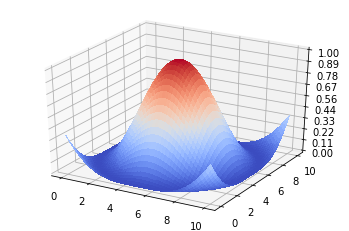

In [ ]:
# Topology
def f_2D_1(x, y, L):
    return .5*(1 + np.cos(np.sqrt((x-L/2)**2+(y-L/2)**2)*np.pi*2/L))

def dfdx_2D(f, dx):
    df = np.zeros_like(f)
    df[1:-1,:] = (f[2:,:] - f[:-2,:])/(dx*2)
    df[0,:] = df[1,:]
    df[-1,:] = df[-2,:]
    return df

def dfdy_2D(f, dy):
    df = np.zeros_like(f)
    df[:,1:-1] = (f[:,2:] - f[:,:-2])/(dy*2)
    df[:,0] = df[:,1]
    df[:,-1] = df[:,-2]
    return df

## Grid
x = np.linspace(0,L,N)  # Spatial grid
dx = L/len(x)
y = np.linspace(0,L,N)  # Spatial grid
dy = L/len(y)

X, Y = np.meshgrid(x, y) # 2D format
Z = f_2D_1(X, Y, L)

# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

**Remark** that this topology is of same shape and magnitude than 1D one.

### MacCormak with topology

In [ ]:
## Algo

# bottom function
f    = f_2D_1(X, Y, L)

# function derivatives
dfdx = dfdx_2D(f, dx)
dfdy = dfdy_2D(f, dy)

# Initial vector u
u = np.zeros((N, N, 3))
u[:,:,0] = eta_0(X, Y) - f
#u[:,:,0] = eta_0_d(X, L) - f
#u[:,:,0] = eta_0_2(X, Y, L) - f
BC(u)

h0  = u[:,:,0]
Eta = [(h0.copy()+f)]

# time step
t  = 0
tf = 10
dt = 0.005
stepte = 0.5
te = stepte

# factors dt/dk
dtdx = dt/dx
dtdy = dt/dy

## MAIN code
while t < tf:
    
    # Predictor
    ustar = np.zeros_like(u)
    F1 = fill_2DF1(u)
    F2 = fill_2DF2(u)
    S = fill_2DS2(u, dfdx, dfdy)
    ustar[:-1,:-1,:] = u[:-1,:-1,:] - dtdx * (F1[1:,:-1,:] - F1[:-1,:-1,:]) - dtdy * (F2[:-1,1:,:] - F2[:-1,:-1,:]) + dt * S[:-1,:-1,:]
    BC(ustar)
    
    # ---------------------------------------------------------------------------------------------------------------------------------------

    # Corrector
    unew = np.zeros_like(u)
    F1 = fill_2DF1(ustar)
    F2 = fill_2DF2(ustar)
    S = fill_2DS2(ustar, dfdx, dfdy)
    
    # ---------------------------------------------------------------------------------------------------------------------------------------

    unew[1:,1:,:] = .5*(ustar[1:,1:,:] + u[1:,1:,:]) - .5*dtdx * (F1[1:,1:,:] - F1[:-1,1:,:]) - .5*dtdy * (F2[1:,1:,:] - F2[1:,:-1,:]) + dt * S[1:,1:,:]
    t = t + dt
    BC(unew)
    u = unew.copy()
    
    # Saving values
    if (t >= te):
        te = te + stepte
        Eta.append(unew[:,:,0].copy() + f)         


##Animation

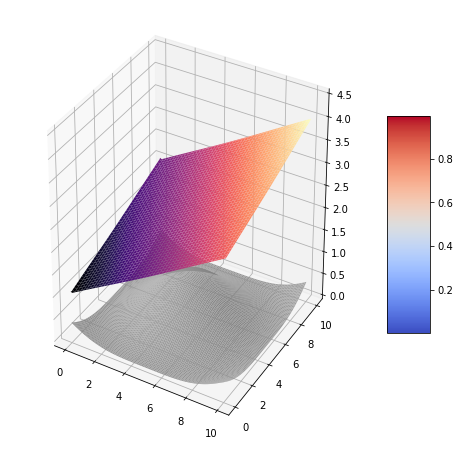

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

#%matplotlib notebook
def update_plot(frame_number, z, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(X, Y, z[frame_number], cmap="magma")

fig = plt.figure(figsize=(8,8))      # Create an empty figure
ax  = fig.gca(projection='3d')
ax.plot_surface(X, Y, f, color='0.75', rstride=1, cstride=1)

plot = [ax.plot_surface(X, Y, Eta[0], color='0.75', rstride=1, cstride=1)]
ax.set_zlim(0,4.5)
fig.colorbar(surf, shrink=0.5, aspect=5)

anim=animation.FuncAnimation(fig, update_plot, len(Eta), fargs=(Eta, plot))  # Animate the solution

#plt.show()
HTML(anim.to_jshtml())

$\Rightarrow$ We observe same behavior than in 1D case (see how behaves the function at the bump and how it is "attached" to it during the 4 first iterations).

The method is stable, at least as much as MacComrack scheme can be (as it was for 1D).

We can see anyway that the 2D model is well modelled and remains stable even though we deal with high waves.

**$\Rightarrow \underline{\text{Conclusion Project}}$ : throughout this project, we have been able to modelize step by step a code describing a hyperbolic differential equation (matter transportation) and as well handling limit cases such as rest lake and dry state.**

**It is however possible to add more physical parameters such as surface tension or to modelize the flow for various IC. As this, the model responds well and we have more hindsight on how to handle wave's discontinuities. We managed to understand and respond to the issue the model brought with him, and this was made possible by a physical approach on our equations that we translated afterwards numerically.**